# Convnext tune

In [ ]:
https://github.com/keras-team/keras/blob/master/keras/applications/convnext.py

In [1]:
import h5py

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
# # general tools
import sys
# from glob import glob

# # data tools
# import time
# import h5py
# import random
# import numpy as np
# from random import shuffle

# import matplotlib.pyplot as plt
# %matplotlib inline

In [4]:
# # deep learning tools
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
# from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

In [39]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [33]:
from tensorflow import keras

In [31]:
from keras_unet_collection import utils as k_utils

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import Model

  
class LayerScale(layers.Layer):
    """Layer scale module.
    References:
      - https://arxiv.org/abs/2103.17239
    Args:
      init_values (float): Initial value for layer scale. Should be within
        [0, 1].
      projection_dim (int): Projection dimensionality.
    Returns:
      Tensor multiplied to the scale.
    """

    def __init__(self, init_values, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.init_values = init_values
        self.projection_dim = projection_dim

    def build(self, input_shape):
        self.gamma = tf.Variable(
            self.init_values * tf.ones((self.projection_dim,))
        )

    def call(self, x):
        return x * self.gamma

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "init_values": self.init_values,
                "projection_dim": self.projection_dim,
            }
        )
        return config
    


def Head(num_classes=1000, name=None):
    """Implementation of classification head of RegNet.
    Args:
      num_classes: number of classes for Dense layer
      name: name prefix
    Returns:
      Classification head function.
    """
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        x = layers.GlobalAveragePooling2D(name=name + "_head_gap")(x)
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dense(num_classes, name=name + "_head_dense")(x)
        return x

    return apply


2022-09-08 13:49:41.251127: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [7]:
MODEL_CONFIGS = {
    "tiny": {
        "depths": [3, 3, 9, 3],
        "projection_dims": [96, 192, 384, 768],
    },
    "small": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [96, 192, 384, 768],
    },
    "base": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [128, 256, 512, 1024],
    },
    "large": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [192, 384, 768, 1536],
    },
    "xlarge": {
        "depths": [3, 3, 27, 3],
        "projection_dims": [256, 512, 1024, 2048],
    },
}

In [13]:
MODEL_CONFIGS["small"]["depths"]

[3, 3, 27, 3]

In [ ]:
depths=[3, 3, 27, 3]
projection_dims=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6
model_name='test'
input_shape=(160, 160, 10)
pooling='max'
classes=1

inputs = layers.Input(shape=input_shape)
x = inputs


# Stem block.
stem = Sequential(
    [
        layers.Conv2D(
            projection_dims[0],
            kernel_size=4,
            strides=4,
            name=model_name + "_stem_conv",
        ),
        layers.LayerNormalization(
            epsilon=1e-6, name=model_name + "_stem_layernorm"
        ),
    ],
    name=model_name + "_stem",
)

# Downsampling blocks.
downsample_layers = []
downsample_layers.append(stem)

num_downsample_layers = 3
for i in range(num_downsample_layers):
    downsample_layer = Sequential(
        [
            layers.LayerNormalization(
                epsilon=1e-6,
                name=model_name + "_downsampling_layernorm_" + str(i),
            ),
            layers.Conv2D(
                projection_dims[i + 1],
                kernel_size=2,
                strides=2,
                name=model_name + "_downsampling_conv_" + str(i),
            ),
        ],
        name=model_name + "_downsampling_block_" + str(i),
    )
    downsample_layers.append(downsample_layer)

depth_drop_rates = [
    float(x) for x in np.linspace(0.0, drop_path_rate, sum(depths))
]

# First apply downsampling blocks and then apply ConvNeXt stages.
cur = 0

num_convnext_blocks = 4

for i in range(num_convnext_blocks):
    x = downsample_layers[i](x)
    for j in range(depths[i]):
        x = ConvNeXtBlock(
            projection_dim=projection_dims[i],
            drop_path_rate=depth_drop_rates[cur + j],
            layer_scale_init_value=layer_scale_init_value,
            name=model_name + f"_stage_{i}_block_{j}",
        )(x)
    cur += depths[i]

x = Head(num_classes=classes, name=model_name)(x)

model = Model(inputs=inputs, outputs=x, name=model_name)

In [49]:
depths=[3, 3, 27, 3]
projection_dim=[96, 192, 384, 768]
drop_path_rate=0.0
layer_scale_init_value=1e-6
model_name='test'
input_shape=(128, 128, 10)
classes=1

IN = layers.Input(shape=input_shape)
X = IN

num_convnext_blocks = 4

# ----- convnext block 0 ----- #

X = layers.Conv2D(projection_dims[0], kernel_size=4, strides=4, name="{}_down0".format(model_name))(X)
X = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_norm".format(model_name))(X)

for j in range(depths[0]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dim[0], kernel_size=7, padding="same",
                               groups=projection_dim[0], name="{}_down0_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down0_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dim[0], name="{}_down0_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down0_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dim[0], name="{}_down0_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dim[0], name="{}_down0_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext


# ----- convnext block 1 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[1], kernel_size=2, strides=2, name="{}_down1".format(model_name))(X)

for j in range(depths[1]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dim[1], kernel_size=7, padding="same",
                               groups=projection_dim[1], name="{}_down1_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down1_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dim[1], name="{}_down1_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down1_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dim[1], name="{}_down1_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dim[1], name="{}_down1_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 2 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[2], kernel_size=2, strides=2, name="{}_down2".format(model_name))(X)

for j in range(depths[2]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dim[2], kernel_size=7, padding="same",
                               groups=projection_dim[2], name="{}_down2_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down2_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dim[2], name="{}_down2_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down2_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dim[2], name="{}_down2_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dim[2], name="{}_down2_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

# ----- convnext block 3 ----- #

X = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_norm".format(model_name))(X)
X = layers.Conv2D(projection_dims[3], kernel_size=2, strides=2, name="{}_down3".format(model_name))(X)

for j in range(depths[3]):
    
    X_convnext = X
    X_convnext = layers.Conv2D(filters=projection_dim[3], kernel_size=7, padding="same",
                               groups=projection_dim[3], name="{}_down3_dconv{}".format(model_name, j))(X_convnext)
    X_convnext = layers.LayerNormalization(epsilon=1e-6, name="{}_down3_dconv{}_norm".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(4 * projection_dim[3], name="{}_down3_dense{}_p1".format(model_name, j))(X_convnext)
    X_convnext = layers.Activation("gelu", name="{}_down3_gelu{}".format(model_name, j))(X_convnext)
    X_convnext = layers.Dense(projection_dim[3], name="{}_down3_dense{}_p2".format(model_name, j))(X_convnext)

    X_convnext = LayerScale(layer_scale_init_value, projection_dim[3], name="{}_down3_layerscale{}".format(model_name, j))(X_convnext)

    X = X + X_convnext

OUT = X

OUT = layers.GlobalAveragePooling2D(name="{}_head_pool".format(model_name))(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6, name="{}_head_norm".format(model_name))(OUT)
OUT = layers.Dense(1, name="{}_head_out".format(model_name))(OUT)

model = Model(inputs=IN, outputs=OUT, name=model_name)

In [50]:
# model = ConvNeXt(
#         depths=MODEL_CONFIGS["small"]["depths"],
#         projection_dims=MODEL_CONFIGS["small"]["projection_dims"],
#         drop_path_rate=0.0,
#         layer_scale_init_value=1e-6,
#         model_name='test',
#         input_shape=(160, 160, 10),
#         pooling='max',
#         classes=1,
#     )

In [51]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

W_old = k_utils.dummy_loader(temp_dir+'CONVNEXT_L_pp10_tune3')
model.set_weights(W_old)

model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=0))

In [54]:
X

<KerasTensor: shape=(None, 4, 4, 768) dtype=float32 (created by layer 'tf.__operators__.add_440')>

In [35]:
ind_pick_from_batch = [1, 2, 5, 9, 10, 11, 12, 13, 17, 18]
L_vars = len(ind_pick_from_batch)

In [40]:
with h5py.File(save_dir_scratch+'VALID_real_lead{}.hdf'.format(21), 'r') as h5io:
    TEST_input = h5io['TEST_input'][4000:8000, ...]
    TEST_target = h5io['TEST_target'][4000:8000, ...]

TEST_target[np.isnan(TEST_target)] = 0.0
TEST_target[TEST_target!=0] = 1.0

TEST_input = TEST_input[..., ind_pick_from_batch]

In [52]:
Y_pred = model.predict([TEST_input,])

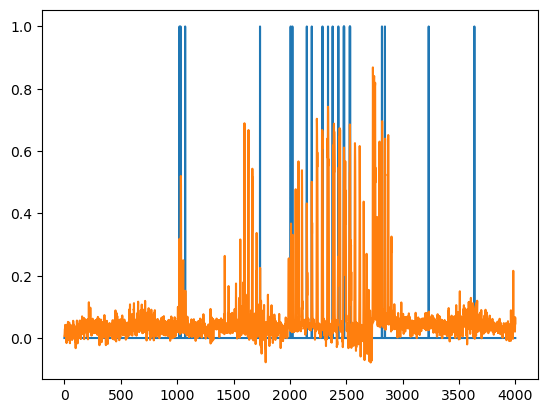

In [53]:
plt.plot(TEST_target)
plt.plot(Y_pred)